Script to demo example usage of the Aspire Multi-Vector encoder which represents documents via contextual sentence embeddings and is trained to make multiple matches between documents using optimal transport, i.e the models:

[`allenai/aspire-contextualsentence-multim-biomed`](https://huggingface.co/allenai/aspire-contextualsentence-multim-biomed)

[`allenai/aspire-contextualsentence-multim-compsci`](https://huggingface.co/allenai/aspire-contextualsentence-multim-compsci)

Requirements:
- transformers version: 4.5.1
- torch version: 1.8.1
- geomloss version: 0.2.4

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import namedtuple
import numpy as np
import torch
from torch import nn as nn
from torch.autograd import Variable
from transformers import AutoModel, AutoTokenizer

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

In [4]:
# Import model, distance, and pre-proc code from examples script.
from ex_aspire_consent_multimatch import AspireConSent, AllPairMaskedWasserstein
from ex_aspire_consent_multimatch import prepare_abstracts

In [7]:
rep_len_tup = namedtuple('RepLen', ['embed', 'abs_lens'])

### Example documents and alignments

For a handful examples, prepare the data, embed it, and visualize the optimal transport plans/alignments for the computed sentence vectors.

In [9]:
# Initialize the tokenizer, model, and distance function.
hf_model_name = 'allenai/aspire-contextualsentence-multim-compsci'
aspire_tok = AutoTokenizer.from_pretrained(hf_model_name)
aspire_mv_model = AspireConSent(hf_model_name)
# Empty dict of hyper params will force class to use defaults.
ot_distance = AllPairMaskedWasserstein({})

In [10]:
ex_abstracts = [
    {'TITLE': "Team Self-Managing Behaviors and Team Effectiveness: The Moderating Effect of Task Routineness",
     'ABSTRACT': ["This study investigates the role of team members’ self-managing behaviors in regard to three dimensions of team effectiveness.",
                  "Furthermore, this study examines the moderating effect of task routineness on these relationships.",
                  "The sample consists of 97 work teams (341 members and 97 immediate supervisors) drawn from a public safety organization.",
                  "Results show that team self-managing behaviors are positively related to team performance, team viability, and team process improvement.",
                  "Results also indicate that task routineness moderates the relationships that team self-managing behaviors have with team performance and team viability such that these relationships are stronger when the level of task routineness is low.",
                  "However, this moderating effect is not significant in regard to the relationship between team self-managing behaviors and team process improvement.",
                  "Taken together, these findings suggest that emphasis on team self-managing behaviors may enhance team effectiveness"]},
    {'TITLE': "Overcoming Barriers to Self-Management in Software Teams",
     'ABSTRACT': ["The basic work unit in innovative software organizations is the team rather than the individual.",
                  "Such teams consist of a small number of people with complementary skills who are committed to a common purpose, set of performance goals, and approach for which they hold themselves mutually accountable.",
                  "Work teams have many advantages, such as increased productivity, innovation, and employee satisfaction.",
                  "However, their implementation doesn't always result in organizational success.",
                  "It isn't enough to put individuals together and expect that they'll automatically know how to work effectively as a team.",
                  "Lack of redundancy and conflict between team and individual autonomy are key issues when transforming from traditional command-and-control management to collaborative self-managing teams."]}
]

In [11]:
# Pre-process the data.
bert_batch, abs_lens, sent_token_idxs = prepare_abstracts(batch_abs=ex_abstracts,
                                                          pt_lm_tokenizer=aspire_tok)

In [12]:
# Get sentence embeddings for the papers.
clsreps, contextual_sent_reps = aspire_mv_model.forward(bert_batch=bert_batch,
                                                        abs_lens=abs_lens,
                                                        sent_tok_idxs=sent_token_idxs)

In [13]:
# Check shapes
print(contextual_sent_reps.shape)
print(f'Number of sentences: {len(ex_abstracts[0]["ABSTRACT"])}, {len(ex_abstracts[1]["ABSTRACT"])}')

torch.Size([2, 7, 768])
Number of sentences: 7, 6


In [14]:
# Package the sentence embeds for use with the distance function
query_embeds = contextual_sent_reps[0,:,:].unsqueeze(0)
cand_embeds = contextual_sent_reps[1,:,:].unsqueeze(0)
qt = rep_len_tup(embed=query_embeds.permute(0, 2, 1), abs_lens=[abs_lens[0]])
ct = rep_len_tup(embed=cand_embeds.permute(0, 2, 1), abs_lens=[abs_lens[1]])

In [15]:
# Compute the wasserstein distance and alignment between abstracts
wd, intermediate_items = ot_distance.compute_distance(query=qt, cand=ct, return_pair_sims=True)

In [16]:
# Get the transport plan
transport_plan = intermediate_items[3].data.numpy()[0,:abs_lens[0],:abs_lens[1]]
transport_plan.shape

(7, 6)

0: This study investigates the role of team members’ self-managing behaviors in regard to three dimensions of team effectiveness.
1: Furthermore, this study examines the moderating effect of task routineness on these relationships.
2: The sample consists of 97 work teams (341 members and 97 immediate supervisors) drawn from a public safety organization.
3: Results show that team self-managing behaviors are positively related to team performance, team viability, and team process improvement.
4: Results also indicate that task routineness moderates the relationships that team self-managing behaviors have with team performance and team viability such that these relationships are stronger when the level of task routineness is low.
5: However, this moderating effect is not significant in regard to the relationship between team self-managing behaviors and team process improvement.
6: Taken together, these findings suggest that emphasis on team self-managing behaviors may enhance team effecti

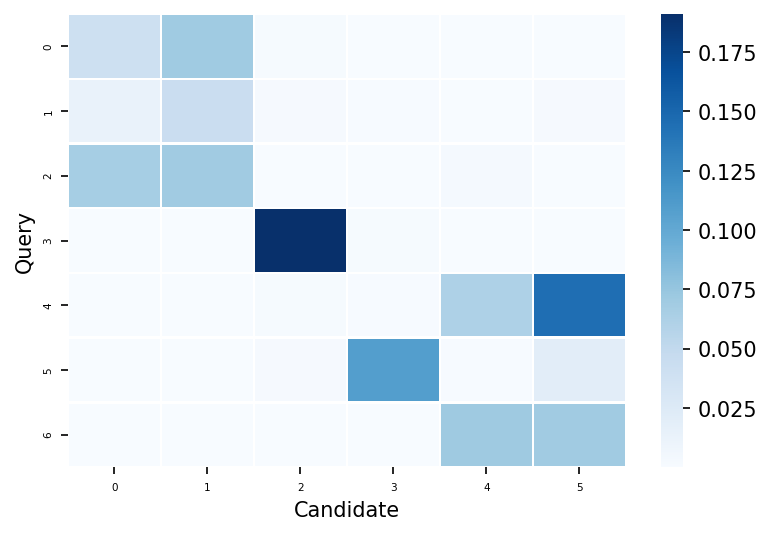

In [18]:
# Print the sentences and plot the optimal transport plan for the pair of abstracts.
print('\n'.join([f'{i}: {s}' for i, s in enumerate(ex_abstracts[0]['ABSTRACT'])]))
print('')
print('\n'.join([f'{i}: {s}' for i, s in enumerate(ex_abstracts[1]['ABSTRACT'])]))
h = sns.heatmap(transport_plan, linewidths=.7, cmap='Blues')
h.set(xlabel='Candidate', ylabel='Query')
h.tick_params(labelsize=5)

In [19]:
ex_abstracts = [
    {'TITLE': "Large scale metric learning from equivalence constraints",
     'ABSTRACT': ["In this paper, we raise important issues on scalability and the required degree of supervision of existing Mahalanobis metric learning methods.",
                  "Often rather tedious optimization procedures are applied that become computationally intractable on a large scale.",
                  "Further, if one considers the constantly growing amount of data it is often infeasible to specify fully supervised labels for all data points.",
                  "Instead, it is easier to specify labels in form of equivalence constraints.",
                  "We introduce a simple though effective strategy to learn a distance metric from equivalence constraints, based on a statistical inference perspective.",
                  "In contrast to existing methods we do not rely on complex optimization problems requiring computationally expensive iterations.",
                  "Hence, our method is orders of magnitudes faster than comparable methods.",
                  "Results on a variety of challenging benchmarks with rather diverse nature demonstrate the power of our method.",
                  "These include faces in unconstrained environments, matching before unseen object instances and person re-identification across spatially disjoint cameras.",
                  "In the latter two benchmarks we clearly outperform the state-of-the-art."]},
    {'TITLE': "PCCA: A new approach for distance learning from sparse pairwise constraints",
     'ABSTRACT': ["This paper introduces Pairwise Constrained Component Analysis (PCCA), a new algorithm for learning distance metrics from sparse pairwise similarity/dissimilarity constraints in high dimensional input space, problem for which most existing distance metric learning approaches are not adapted.",
                  "PCCA learns a projection into a low-dimensional space where the distance between pairs of data points respects the desired constraints, exhibiting good generalization properties in presence of high dimensional data.",
                  "The paper also shows how to efficiently kernelize the approach.",
                  "PCCA is experimentally validated on two challenging vision tasks, face verification and person re-identification, for which we obtain state-of-the-art results."]}
]

In [20]:
# Pre-process the data.
bert_batch, abs_lens, sent_token_idxs = prepare_abstracts(batch_abs=ex_abstracts,
                                                          pt_lm_tokenizer=aspire_tok)

# Get sentence embeddings for the papers.
clsreps, contextual_sent_reps = aspire_mv_model.forward(bert_batch=bert_batch,
                                                        abs_lens=abs_lens,
                                                        sent_tok_idxs=sent_token_idxs)

# Package the sentence embeds for use with the distance function
query_embeds = contextual_sent_reps[0,:,:].unsqueeze(0)
cand_embeds = contextual_sent_reps[1,:,:].unsqueeze(0)
qt = rep_len_tup(embed=query_embeds.permute(0, 2, 1), abs_lens=[abs_lens[0]])
ct = rep_len_tup(embed=cand_embeds.permute(0, 2, 1), abs_lens=[abs_lens[1]])

# Compute the wasserstein distance and alignment between abstracts
wd, intermediate_items = ot_distance.compute_distance(query=qt, cand=ct, return_pair_sims=True)

# Get the transport plan
transport_plan = intermediate_items[3].data.numpy()[0,:abs_lens[0],:abs_lens[1]]

0: In this paper, we raise important issues on scalability and the required degree of supervision of existing Mahalanobis metric learning methods.
1: Often rather tedious optimization procedures are applied that become computationally intractable on a large scale.
2: Further, if one considers the constantly growing amount of data it is often infeasible to specify fully supervised labels for all data points.
3: Instead, it is easier to specify labels in form of equivalence constraints.
4: We introduce a simple though effective strategy to learn a distance metric from equivalence constraints, based on a statistical inference perspective.
5: In contrast to existing methods we do not rely on complex optimization problems requiring computationally expensive iterations.
6: Hence, our method is orders of magnitudes faster than comparable methods.
7: Results on a variety of challenging benchmarks with rather diverse nature demonstrate the power of our method.
8: These include faces in unconstr

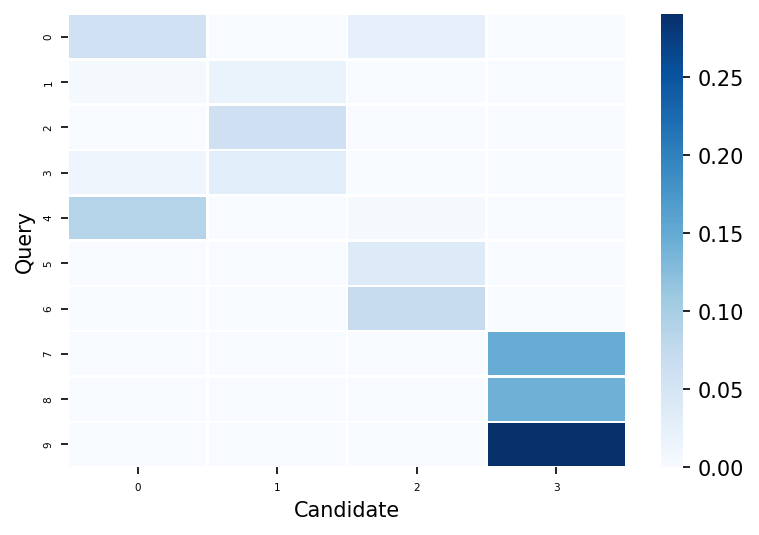

In [21]:
# Print the sentences and plot the optimal transport plan for the pair of abstracts.
print('\n'.join([f'{i}: {s}' for i, s in enumerate(ex_abstracts[0]['ABSTRACT'])]))
print('')
print('\n'.join([f'{i}: {s}' for i, s in enumerate(ex_abstracts[1]['ABSTRACT'])]))
h = sns.heatmap(transport_plan, linewidths=.7, cmap='Blues')
h.set(xlabel='Candidate', ylabel='Query')
h.tick_params(labelsize=5)

In [22]:
ex_abstracts = [
    {'TITLE': "End-to-end learning for music audio",
     'ABSTRACT': ["Content-based music information retrieval tasks have traditionally been solved using engineered features and shallow processing architectures.",
                  "In recent years, there has been increasing interest in using feature learning and deep architectures instead, thus reducing the required engineering effort and the need for prior knowledge.",
                  "However, this new approach typically still relies on mid-level representations of music audio, e.g. spectrograms, instead of raw audio signals.",
                  "In this paper, we investigate whether it is possible to apply feature learning directly to raw audio signals.",
                  "We train convolutional neural networks using both approaches and compare their performance on an automatic tagging task.",
                  "Although they do not outperform a spectrogram-based approach, the networks are able to autonomously discover frequency decompositions from raw audio, as well as phase-and translation-invariant feature representations."]},
    {'TITLE': "Speech acoustic modeling from raw multichannel waveforms",
     'ABSTRACT': ["Standard deep neural network-based acoustic models for automatic speech recognition (ASR) rely on hand-engineered input features, typically log-mel filterbank magnitudes.",
                  "In this paper, we describe a convolutional neural network - deep neural network (CNN-DNN) acoustic model which takes raw multichannel waveforms as input, i.e. without any preceding feature extraction, and learns a similar feature representation through supervised training.",
                  "By operating directly in the time domain, the network is able to take advantage of the signal's fine time structure that is discarded when computing filterbank magnitude features.",
                  "This structure is especially useful when analyzing multichannel inputs, where timing differences between input channels can be used to localize a signal in space.",
                  "The first convolutional layer of the proposed model naturally learns a filterbank that is selective in both frequency and direction of arrival, i.e. a bank of bandpass beamformers with an auditory-like frequency scale.",
                  "When trained on data corrupted with noise coming from different spatial locations, the network learns to filter them out by steering nulls in the directions corresponding to the noise sources.",
                  "Experiments on a simulated multichannel dataset show that the proposed acoustic model outperforms a DNN that uses log-mel filterbank magnitude features under noisy and reverberant conditions."]}
]

In [23]:
# Pre-process the data.
bert_batch, abs_lens, sent_token_idxs = prepare_abstracts(batch_abs=ex_abstracts,
                                                          pt_lm_tokenizer=aspire_tok)

# Get sentence embeddings for the papers.
clsreps, contextual_sent_reps = aspire_mv_model.forward(bert_batch=bert_batch,
                                                        abs_lens=abs_lens,
                                                        sent_tok_idxs=sent_token_idxs)

# Package the sentence embeds for use with the distance function
query_embeds = contextual_sent_reps[0,:,:].unsqueeze(0)
cand_embeds = contextual_sent_reps[1,:,:].unsqueeze(0)
qt = rep_len_tup(embed=query_embeds.permute(0, 2, 1), abs_lens=[abs_lens[0]])
ct = rep_len_tup(embed=cand_embeds.permute(0, 2, 1), abs_lens=[abs_lens[1]])

# Compute the wasserstein distance and alignment between abstracts
wd, intermediate_items = ot_distance.compute_distance(query=qt, cand=ct, return_pair_sims=True)

# Get the transport plan
transport_plan = intermediate_items[3].data.numpy()[0,:abs_lens[0],:abs_lens[1]]

0: Content-based music information retrieval tasks have traditionally been solved using engineered features and shallow processing architectures.
1: In recent years, there has been increasing interest in using feature learning and deep architectures instead, thus reducing the required engineering effort and the need for prior knowledge.
2: However, this new approach typically still relies on mid-level representations of music audio, e.g. spectrograms, instead of raw audio signals.
3: In this paper, we investigate whether it is possible to apply feature learning directly to raw audio signals.
4: We train convolutional neural networks using both approaches and compare their performance on an automatic tagging task.
5: Although they do not outperform a spectrogram-based approach, the networks are able to autonomously discover frequency decompositions from raw audio, as well as phase-and translation-invariant feature representations.

0: Standard deep neural network-based acoustic models f

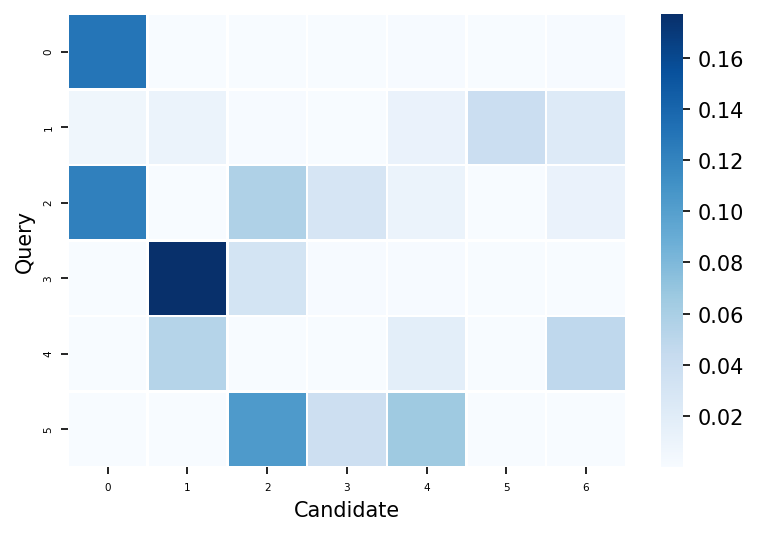

In [24]:
# Print the sentences and plot the optimal transport plan for the pair of abstracts.
print('\n'.join([f'{i}: {s}' for i, s in enumerate(ex_abstracts[0]['ABSTRACT'])]))
print('')
print('\n'.join([f'{i}: {s}' for i, s in enumerate(ex_abstracts[1]['ABSTRACT'])]))
h = sns.heatmap(transport_plan, linewidths=.7, cmap='Blues')
h.set(xlabel='Candidate', ylabel='Query')
h.tick_params(labelsize=5)